# 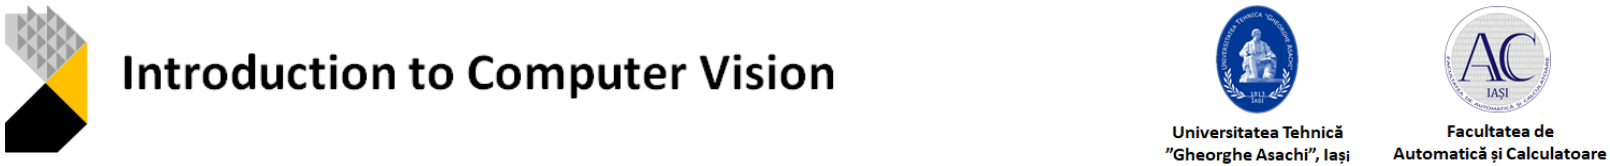

  The 2022 Intro to Computer Vision labs will be run in Google Colaboratory, a Jupyter notebook environment that runs entirely in the cloud, you don't need to download anything. To run these labs, you must have a Google account.

Step 1: click on the assignment invite link -> **Accept this assignment**. Refresh page -> individual repo for the specific assignment is created automatically

Step 2: Navigate to http://colab.research.google.com/github -> Click the **Include Private Repos** checkbox -> **select the correct repo** (SistemeDeVedereArtificiala/assignment_name-student_name) -> Click on the jupyter notebook of the current assignment

Step 3: [GitHub sign-in window] In the popup window, sign-in to your Github account and authorize Colab to read the private files.

Step 4: [in colab] **File** -> **Save a copy to GitHub**. Select the correct repository for the SPECIFIC assignment -> Click the **Include Colab Link** -> Click **OK**

Step 5: [in colab] Navigate to the **Runtime** tab --> **Change runtime type**, under **Hardware accelerator** select **GPU/TPU** (tensor processing unit) according to your needs. 
  
  <font color='red'>Read the suggestions and accomplish all tasks marked with **#TODO**.

!!! At the end of each laboratory **REPEAT step 4 in order to SAVE** the answers to your private repository (individual for each assignment)</font>

# Project 3: Image stitching

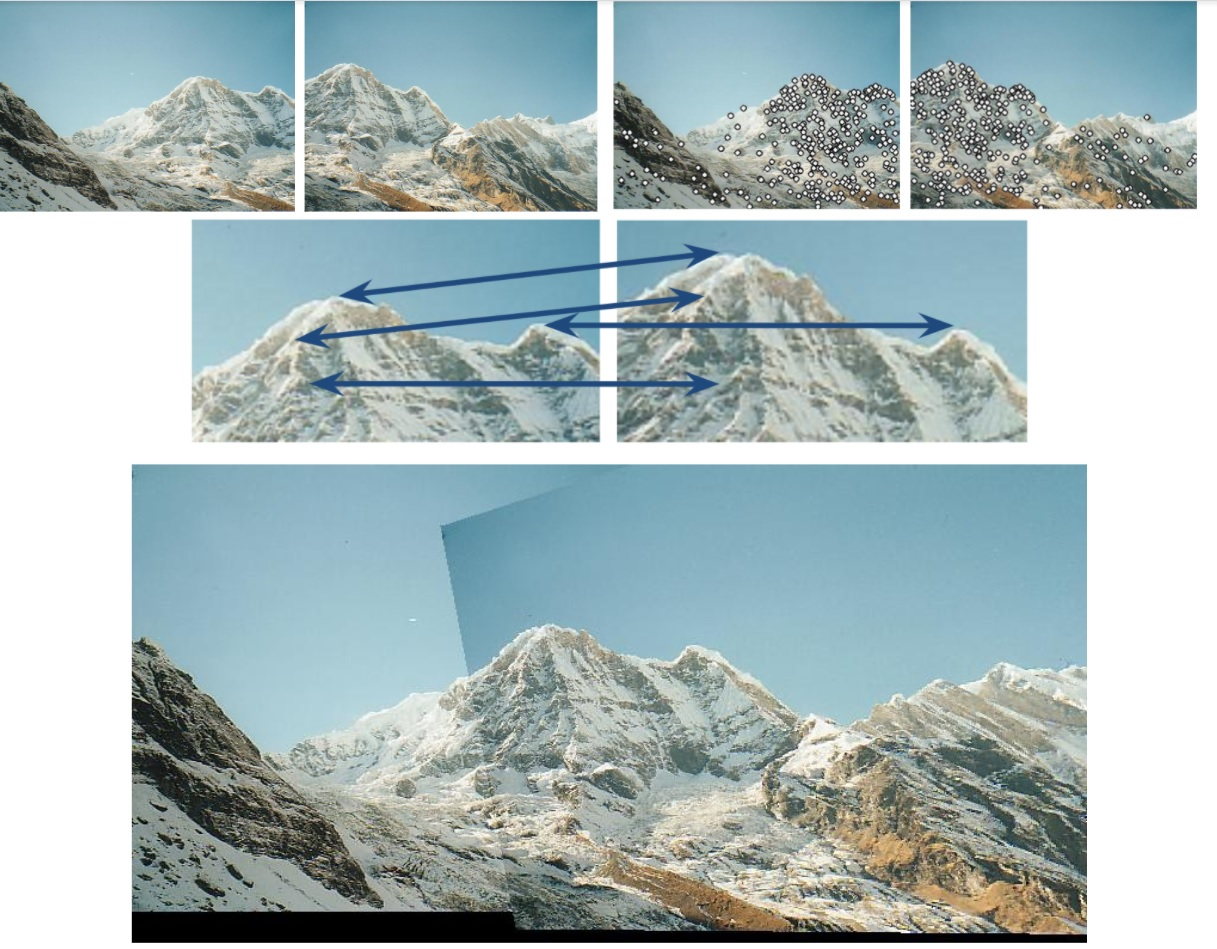

## Week 2: RANSAC & perspective transform
###The process of creating a panoramic image consists of the following steps:
1.  Detect keypoints and descriptors (done last week)
2.  Detect a set of matching points that is present in both images - overlapping area (done last week) **
3.  **Apply the RANSAC method to improve the matching process detection (to do)**
4.  **Apply perspective transformation on one image using the other image as a reference frame (to do)**
5.  **Stitch images together (to do)**

In [ ]:
!pip install opencv-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 1.7 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6 MB 1.4 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#TODO: add test images to My Drive: https://drive.google.com/drive/folders/1fu9tFLtbUKBQUS3ZN413ctnBkiGKADpc?usp=sharing

In [ ]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from imutils import paths
import argparse
import imutils

#TODO: compute sorted image paths at specified location (paths.list_images)
# loading images
path = "/content/drive/My Drive/proiect3/panorama/"


#TODO: read all images (cv2.imread, append())
#loop over the image paths, load each one and add them to images[]
images = []
#code here
for i in range(1,5):
  new_path = path+"yosemite"+str(i)+".jpg"
  images.append(cv2.imread(new_path))
  


In [ ]:
#TODO: compute keypoints (keypoints1, keypoints2) & descriptors using SURF
# match the descriptors using a FLANN based matcher
# filter matches using Lowe's ratio test (good_matches)
# draw matches (img_matches)

def compute_KP_matches(img1, img2): 
  #code here

  surf = cv2.xfeatures2d.SURF_create(400)
  keypoints1, desc1 = surf.detectAndCompute(img1,None)
  keypoints2, desc2 = surf.detectAndCompute(img2,None)

  matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
  knn_matches = matcher.knnMatch(desc1, desc2, 2)

  ratio_thresh = 0.7
  good_matches = []
  for m,n in knn_matches:
      if m.distance < ratio_thresh * n.distance:
          good_matches.append(m)

  img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), dtype=np.uint8)
  cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  return keypoints1, keypoints2, good_matches, img_matches

###What is a homography matrix?
In the field of computer vision, any two images of the same scene are related by a homography. It is a transformation that maps the points in one image to the corresponding points in the other image. The two images can lay on the same surface in space or they are taken by rotating the camera along its optical axis. The essence of the homography is the simple 3x3 matrix called the homography matrix.


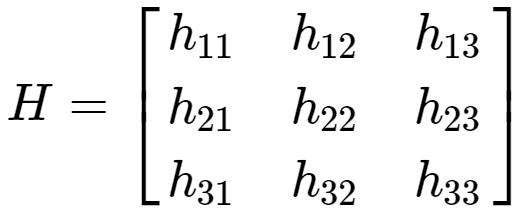

We can apply this matrix to any point in the image. For example, if we take a point A(x1,y1) in the first image we can use a homography matrix to map this point A to the corresponding point B(x2,y2) in the second image.

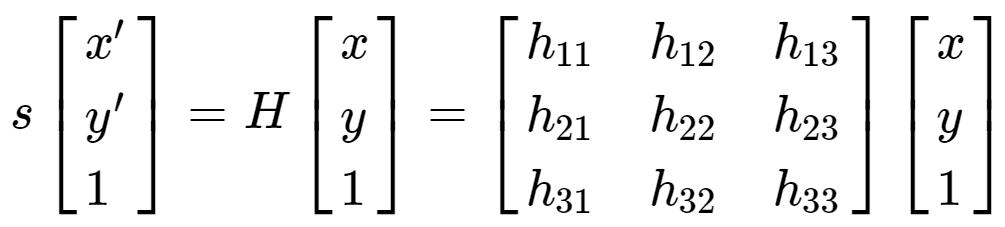

Now, using this technique we can easily stitch our images together. It is important to note that when we match feature points between two images, we only accept those matches that fall on the corresponding epipolar lines. We need these good matches to estimate the homography matrix. We detected a large number of keypoints and we need to reject some of them to retain the best ones.

As we already explained this 3x3 matrix will be used to transform the second image to have the same perspective as the first one which will be kept as the reference frame. Then, we will extract information about the transformation of the second image and use that information to align the second image with the first one.

To find this transformation matrix, we need to extract coordinates of a minimum of 4 points in the first image and corresponding 4 points in the second image. These points are related by homography so we can apply a transformation to change the perspective of the second image using the first image as a reference frame. In the following image, you can see an example of this transformation.


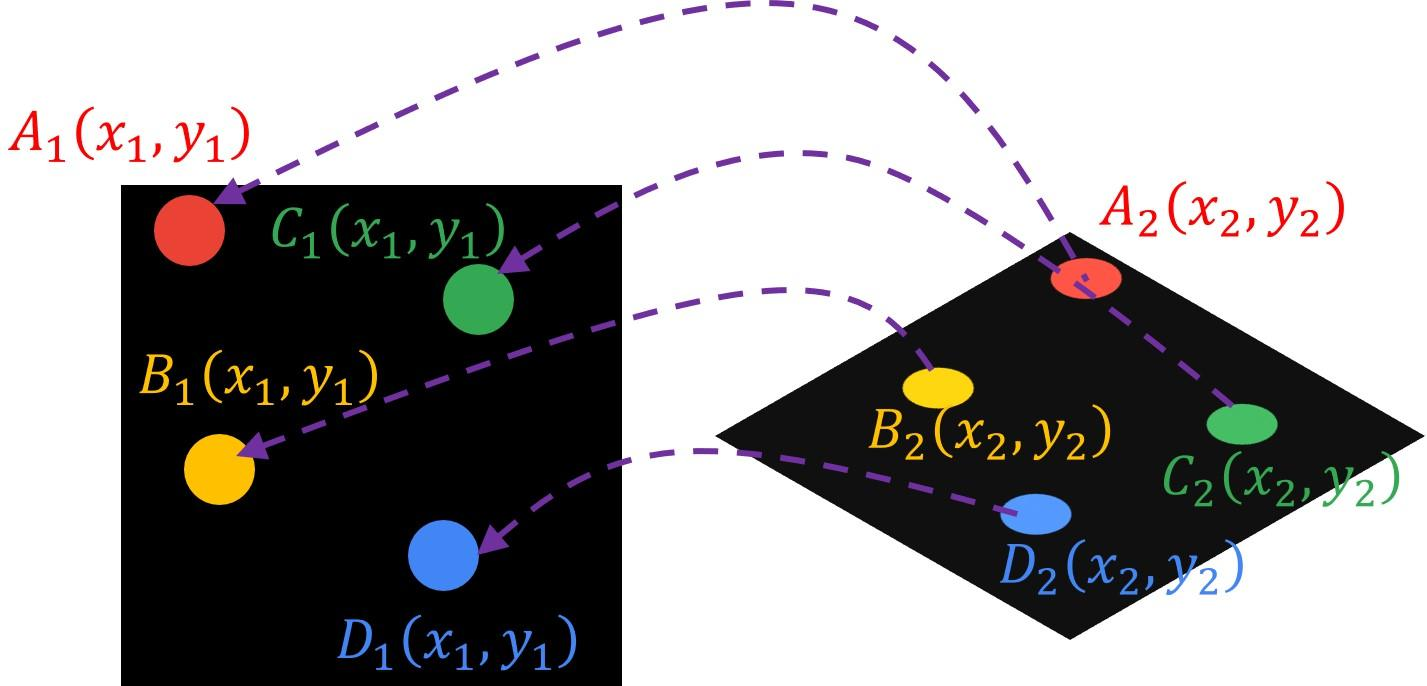

###RANdom SAmple Consensus (RANSAC)
 
* An example of a “voting”-based fitting scheme
* Each hypothesis gets voted on by each data point, best hypothesis wins
* There are many other types of voting schemes
 > Hough transforms
 
**General version:** 
1. Randomly choose s samples
  
  > Typically s = minimum sample size that lets you fit a model
2. Fit a model (e.g., line) to those samples
3. Count the number of inliers that approximately fit the model
4. Repeat N times
5. Choose the model that has the largest set of inliers
 
**Idea:**
1. Given a hypothesized line
2. Count the number of points that “agree” with the line
  > “Agree” = within a small distance of the line 
  
  > I.e., the inliers to that line
3.For all possible lines, select the one with the largest number of inliers


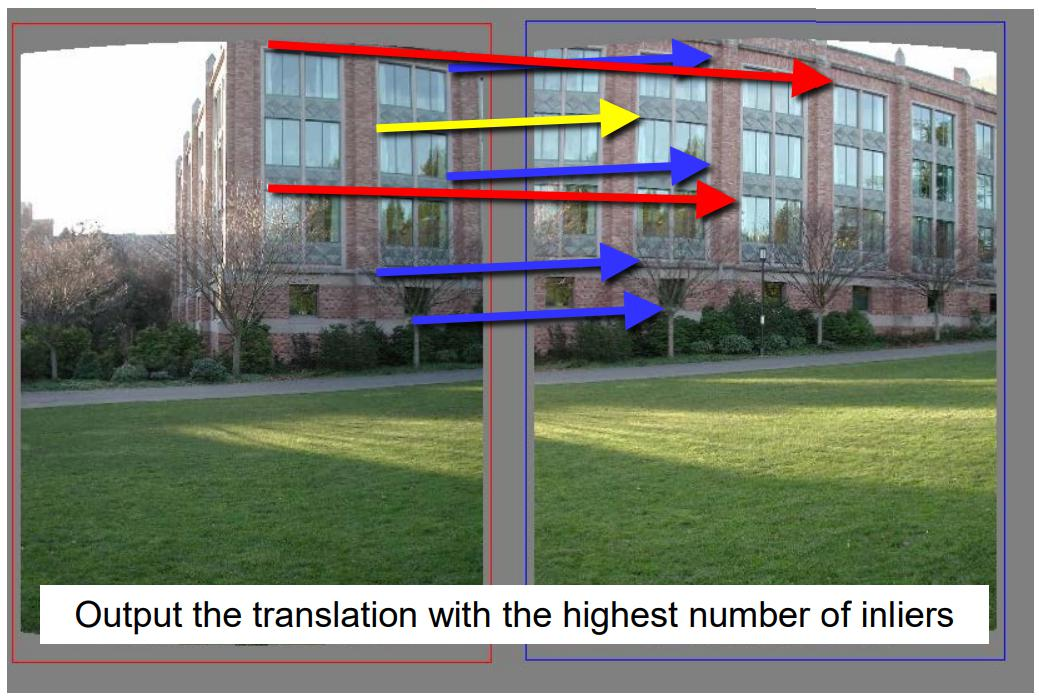

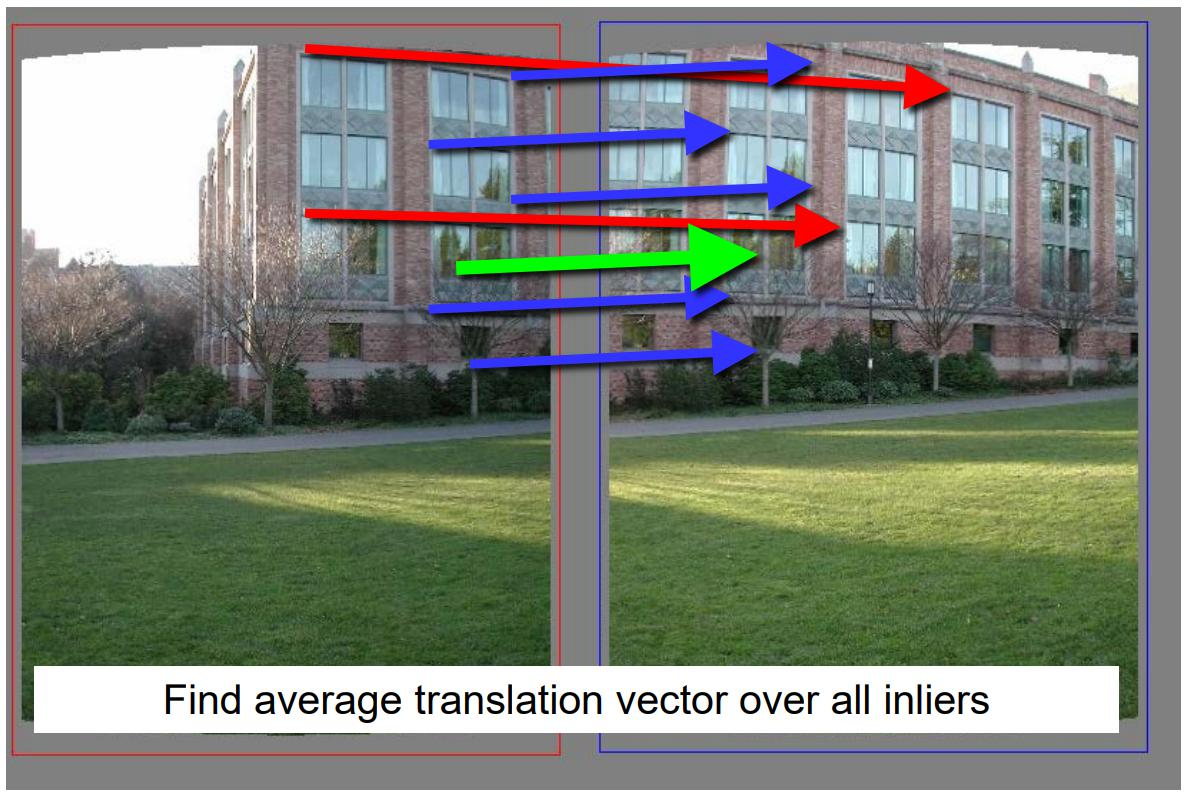

In [ ]:
from logging import exception
#TODO: compute Homography using RANSAC (cv2.findHomography)
# minimum matches after filtering > 10

def find_H(keypoints1, keypoints2, good_matches):
  if len(good_matches) > 10:
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
  else:
    print( "Not enough matches are found - {}/{}".format(len(good_matches), 5) )
    raise Exception("not enough matches!")
  return H

In [ ]:
#TODO: wrap images (cv2.perspectiveTransform, cv2.warpPerspective)
# corners can be used to wrap perspective

def warp_images(img1, img2, H):
  #code here
  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
  translation_dist = [-x_min,-y_min]
  
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img

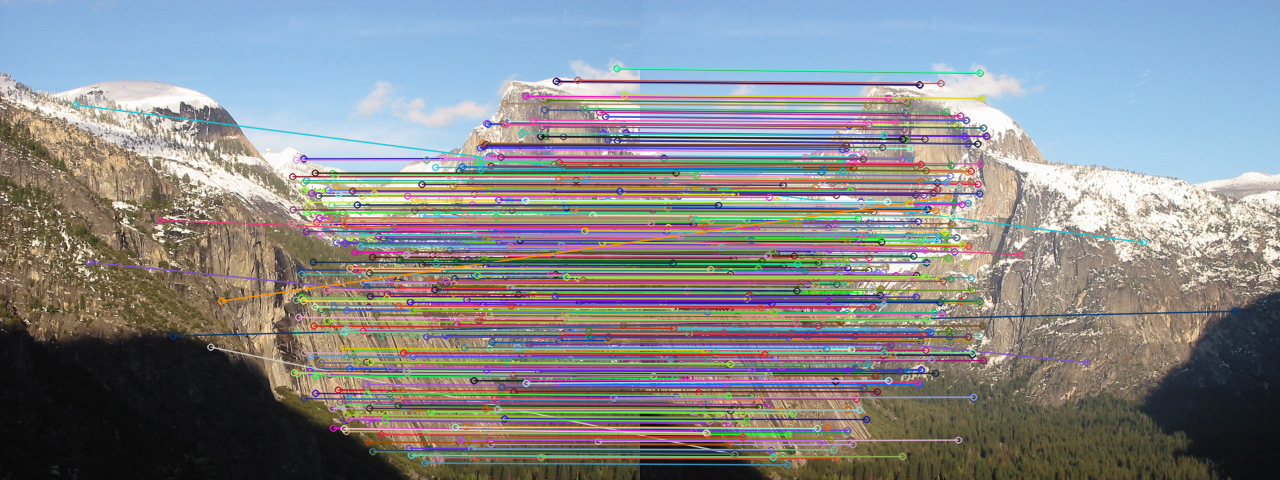

In [ ]:
from google.colab.patches import cv2_imshow
keypoints1, keypoints2, good_matches, img_matches = compute_KP_matches(images[0], images[1])
cv2_imshow(img_matches)

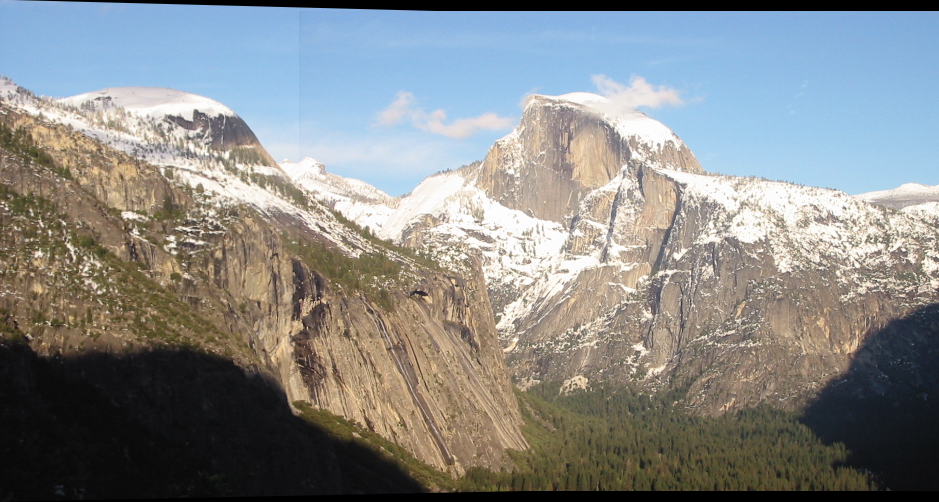

In [ ]:
H=find_H(keypoints1, keypoints2, good_matches)
img12=warp_images(images[1], images[0], H)
cv2_imshow(img12)

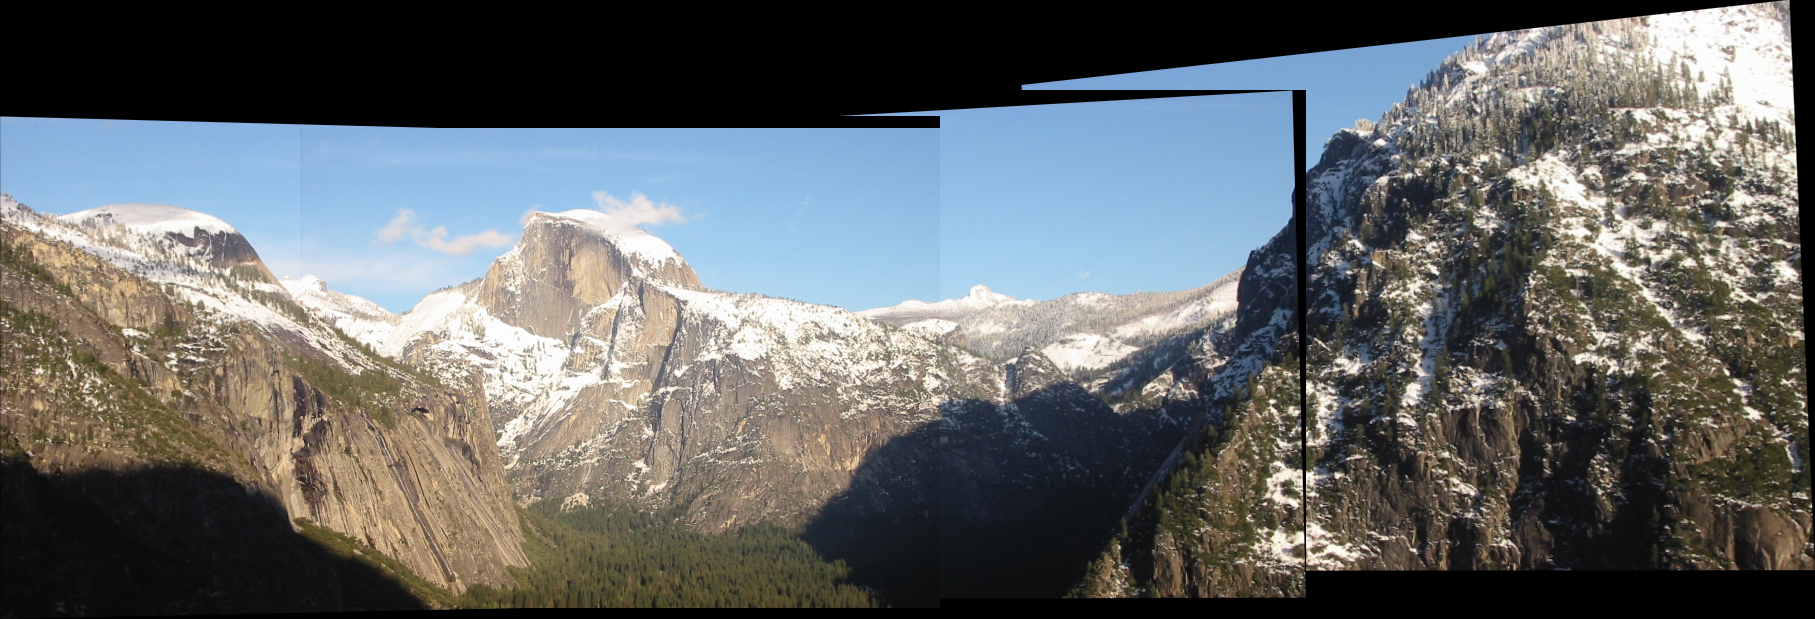

In [ ]:
keypoints1, keypoints2, good_matches, img_matches = compute_KP_matches(images[0], images[1])
H=find_H(keypoints1, keypoints2, good_matches)
img12=warp_images(images[1], images[0], H)
for i in range(1,4):
  keypoints1, keypoints2, good_matches, img_matches = compute_KP_matches(images[i], img12)
  H=find_H(keypoints1, keypoints2, good_matches)
  img12=warp_images(img12, images[i], H)
cv2_imshow(img12)

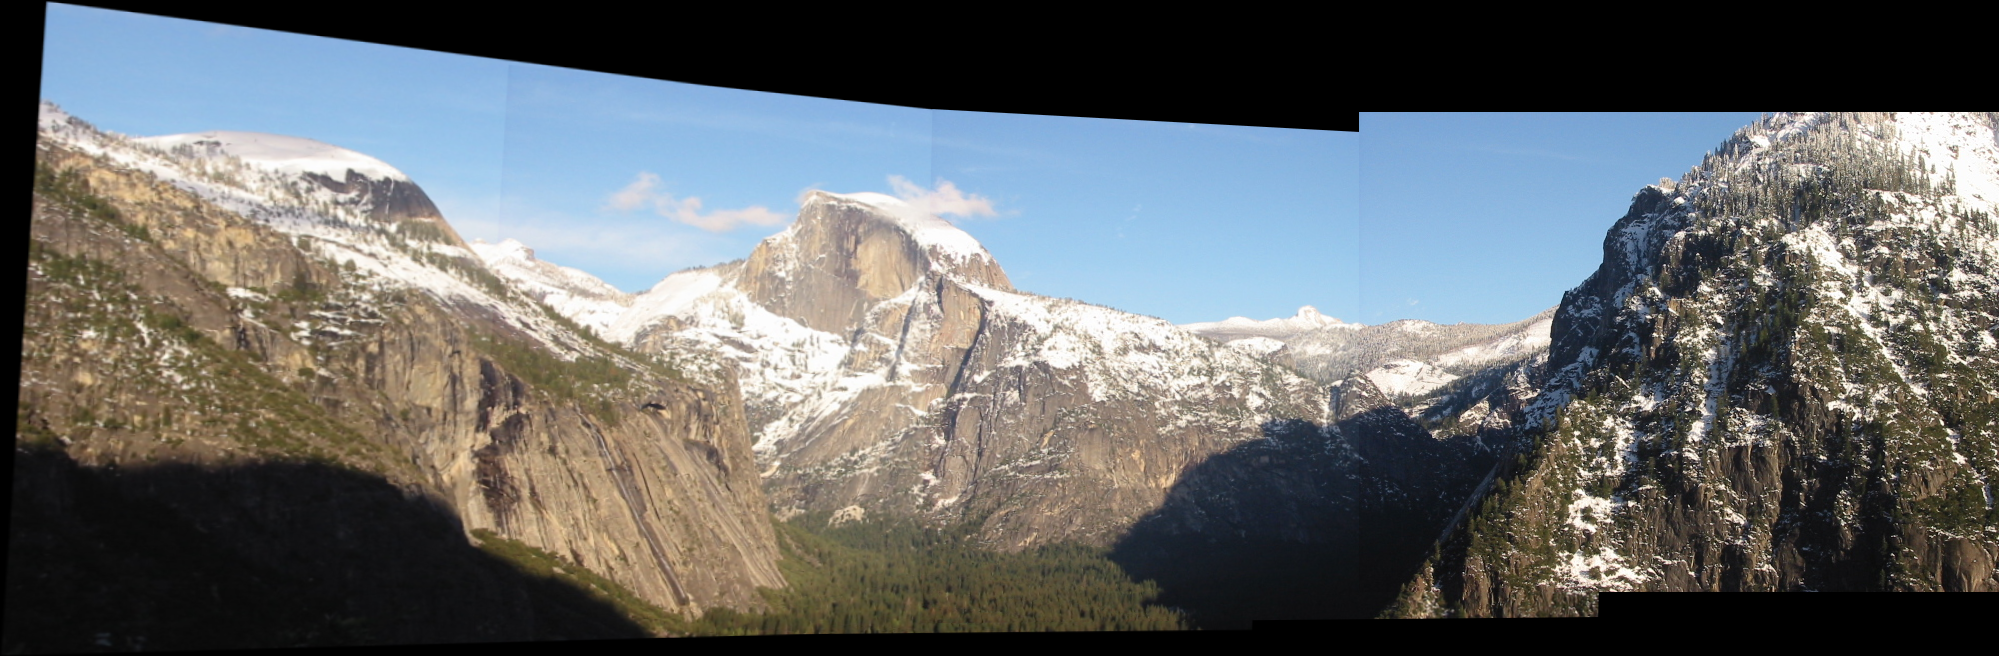

In [ ]:
"""
#TODO: test the above method on images from campus/panorama (18 images)
path = "/content/drive/My Drive/proiect3/campus/panorama/"


#TODO: read all images (cv2.imread, append())
#loop over the image paths, load each one and add them to images[]
images = []
#code here
for i in range(0,18):
  if(i<10):
    new_path = path+"campus_00"+str(i)+".jpg"
    images.append(cv2.imread(new_path))
  else:
    new_path = path+"campus_0"+str(i)+".jpg"
    images.append(cv2.imread(new_path))

keypoints1, keypoints2, good_matches, img_matches = compute_KP_matches(images[0], images[1])
H=find_H(keypoints1, keypoints2, good_matches)
img12=warp_images(images[1], images[0], H)
for i in range(1,19):
  try:
    keypoints1, keypoints2, good_matches, img_matches = compute_KP_matches(images[i], img12)
    H=find_H(keypoints1, keypoints2, good_matches)
    img12=warp_images(img12, images[i], H)
  except:
    continue
cv2_imshow(img12)
"""

'\n#TODO: test the above method on images from campus/panorama (18 images)\npath = "/content/drive/My Drive/proiect3/campus/panorama/"\n\n\n#TODO: read all images (cv2.imread, append())\n#loop over the image paths, load each one and add them to images[]\nimages = []\n#code here\nfor i in range(0,18):\n  if(i<10):\n    new_path = path+"campus_00"+str(i)+".jpg"\n    images.append(cv2.imread(new_path))\n  else:\n    new_path = path+"campus_0"+str(i)+".jpg"\n    images.append(cv2.imread(new_path))\n\nkeypoints1, keypoints2, good_matches, img_matches = compute_KP_matches(images[0], images[1])\nH=find_H(keypoints1, keypoints2, good_matches)\nimg12=warp_images(images[1], images[0], H)\nfor i in range(1,19):\n  try:\n    keypoints1, keypoints2, good_matches, img_matches = compute_KP_matches(images[i], img12)\n    H=find_H(keypoints1, keypoints2, good_matches)\n    img12=warp_images(img12, images[i], H)\n  except:\n    continue\ncv2_imshow(img12)\n'

In [ ]:
#TODO: Alternative solution for a 360 panorama